## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, compute the camera calibration using chessboard images

In [1]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)

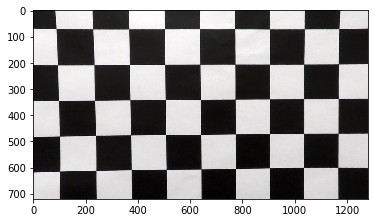

In [2]:
#check indistorted chessboard
img = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)
plt.imshow(undist)

### Load and undistort image

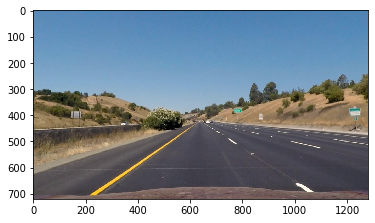

In [3]:
raw_img = mpimg.imread('test_images/straight_lines1.jpg')
#raw_img = mpimg.imread('test_images/test5.jpg')
undist = cv2.undistort(raw_img, cameraMatrix, distCoeffs, None, cameraMatrix)
plt.imshow(undist)

### Gradient & Color Thresholding

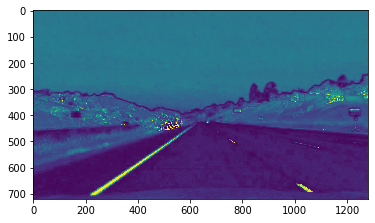

In [4]:
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
plt.imshow(s_channel)

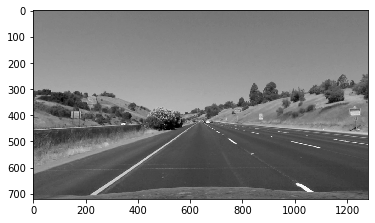

In [5]:
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

In [6]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
abs_sobelx = np.abs(sobelx)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

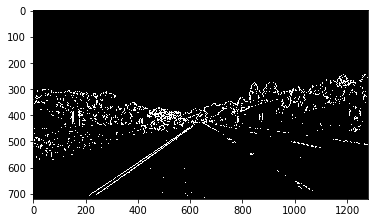

In [7]:
grad_thresh_min = 20
grad_thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel>grad_thresh_min) & (scaled_sobel<grad_thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')

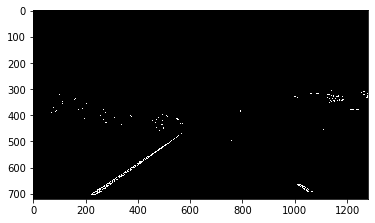

In [8]:
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel>s_thresh_min) & (s_channel<s_thresh_max)] = 1
plt.imshow(s_binary, cmap='gray')

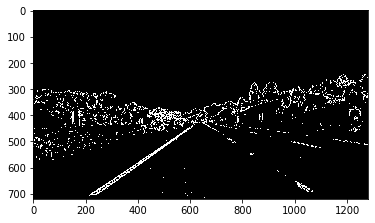

In [9]:
thresh_binary = np.zeros_like(s_channel)
thresh_binary[(s_binary==1) | (sxbinary==1)] = 1
plt.imshow(thresh_binary, cmap='gray')

### Warp perspective to bird's eye

In [10]:
src = np.float32([[592, 450],
                  [688, 450],
                  [1084, 700],
                  [220, 700]])
dst = np.float32([[300, 300], 
                  [300+864, 300], 
                  [300+864, 300+864], 
                  [300, 300+864]])

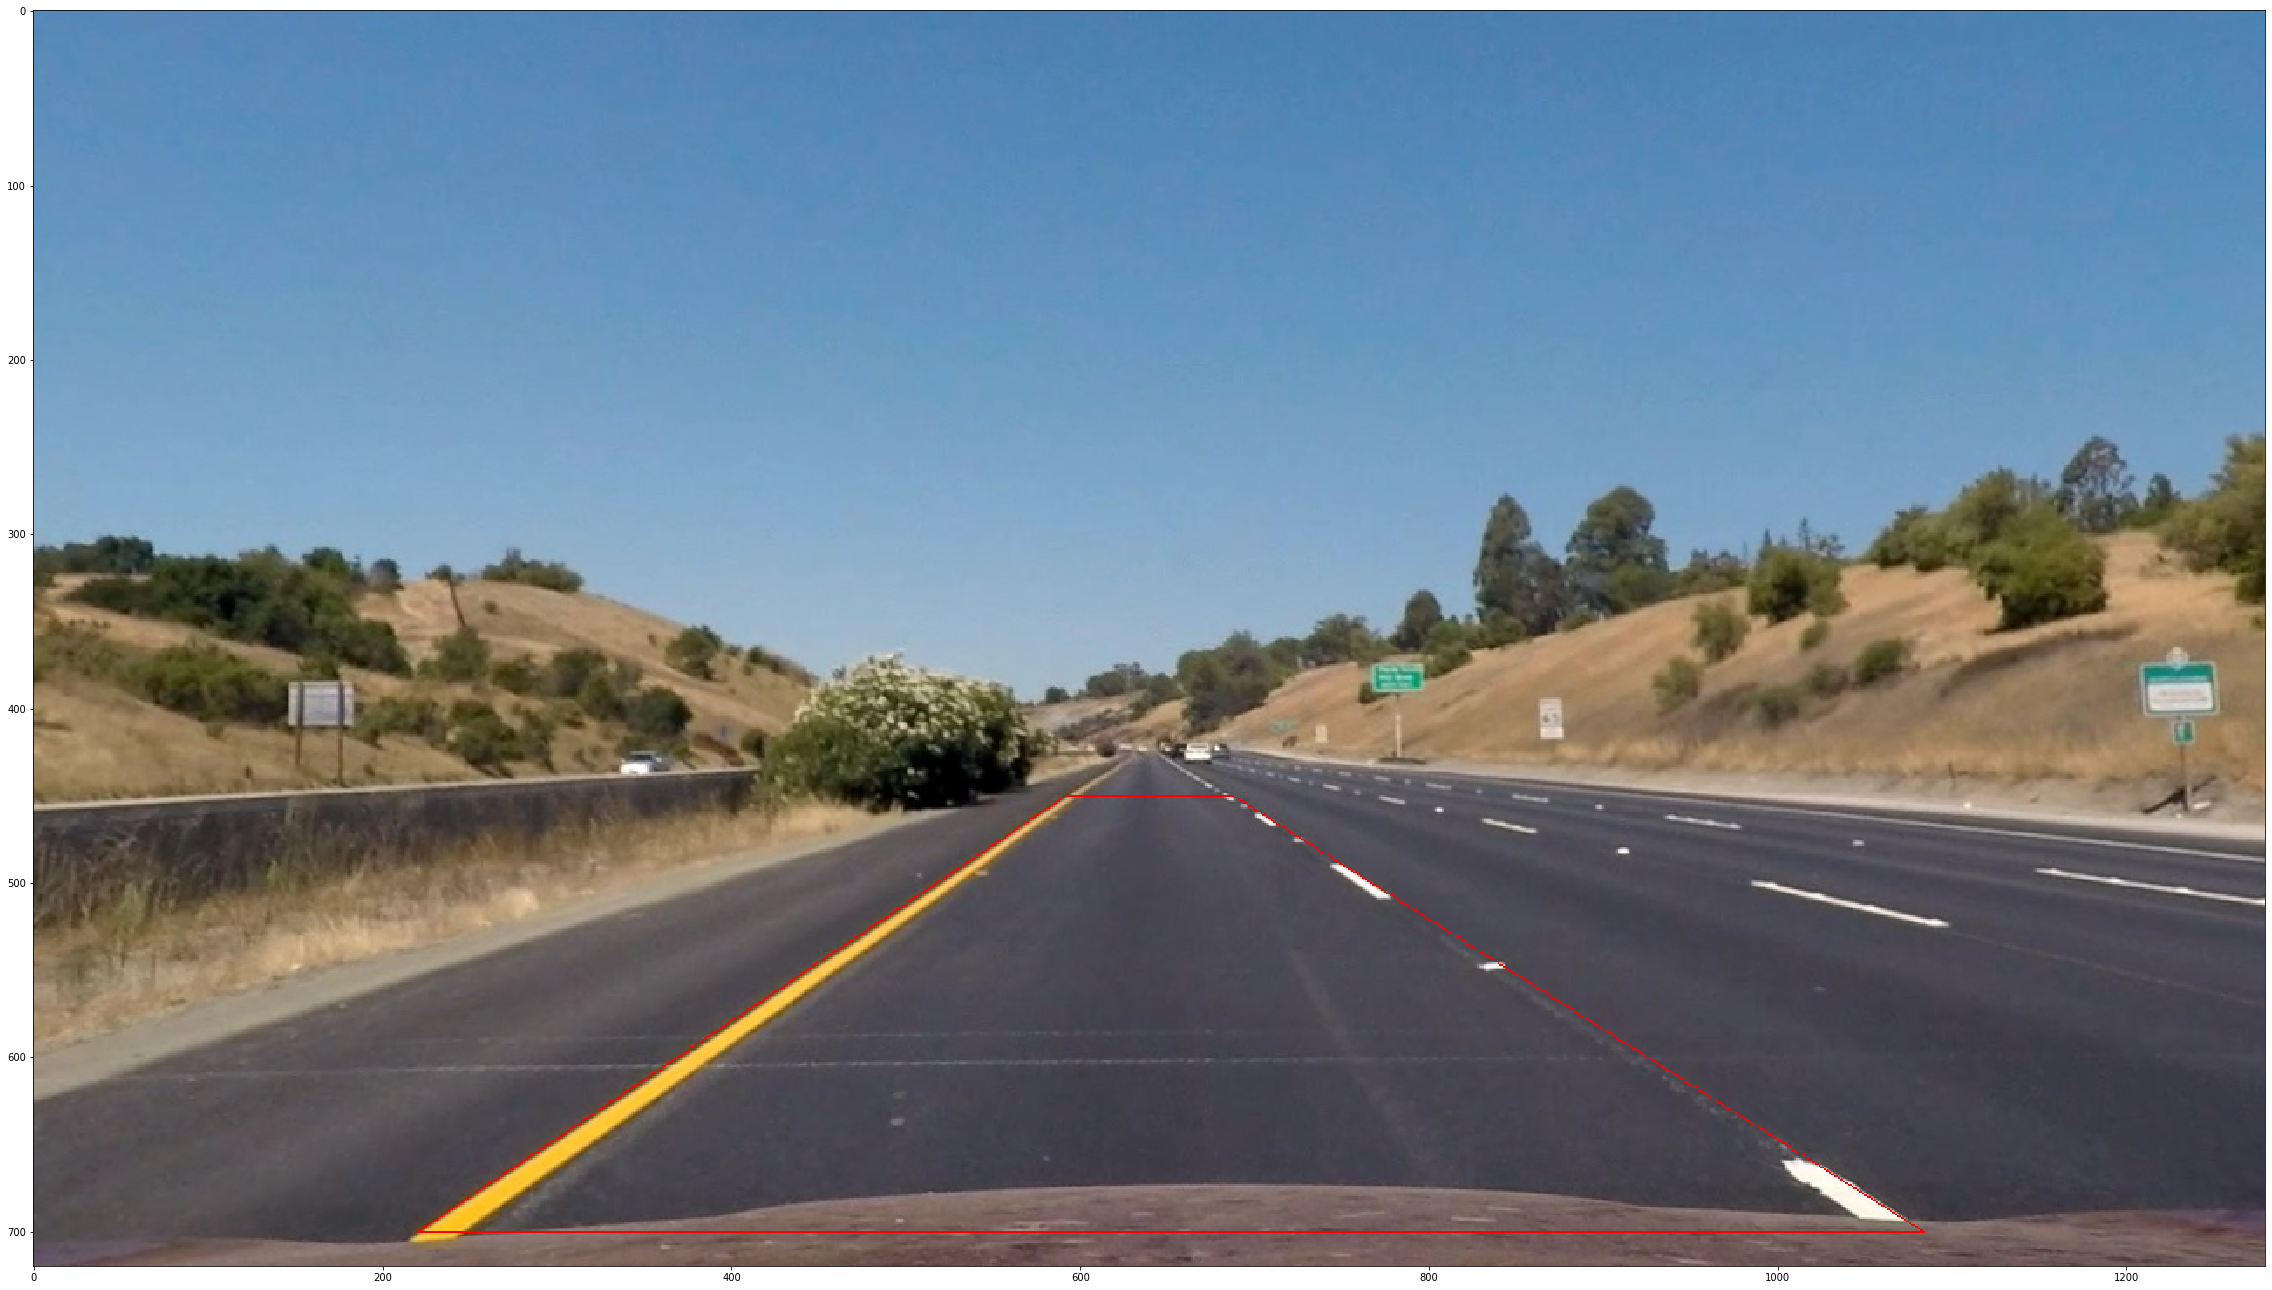

In [11]:
warp_poly = np.copy(undist)
cv2.polylines(warp_poly, [np.int32(src)], True,(255,0,0), thickness=1)
plt.figure(figsize = (40,40))
plt.imshow(warp_poly)

In [12]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

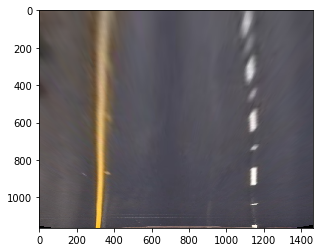

In [13]:
warped_shape = (1464,1164)
warped_undist = cv2.warpPerspective(undist, M, warped_shape, flags=cv2.INTER_LINEAR)
plt.imshow(warped_undist)

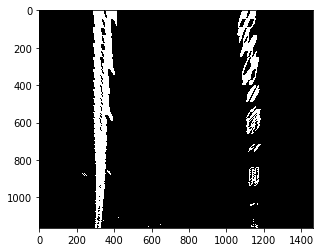

In [14]:
binary_warped = cv2.warpPerspective(thresh_binary, M, warped_shape, flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap='gray')

### Sliding window lane detection

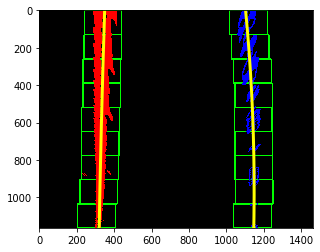

In [15]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 5) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = [ind for ind in range(len(nonzerox)) 
                        if nonzerox[ind] >= win_xleft_low 
                        and nonzerox[ind] < win_xleft_high
                        and nonzeroy[ind] >= win_y_low
                        and nonzeroy[ind] < win_y_high]
        good_right_inds = [ind for ind in range(len(nonzerox)) 
                        if nonzerox[ind] >= win_xright_low 
                        and nonzerox[ind] < win_xright_high
                        and nonzeroy[ind] >= win_y_low
                        and nonzeroy[ind] < win_y_high]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
        #pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.int32(np.concatenate(left_lane_inds))
        right_lane_inds = np.int32(np.concatenate(right_lane_inds))
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow', lw=3)
    plt.plot(right_fitx, ploty, color='yellow', lw=3)

    return out_img, left_fit, right_fit


out_img, left_fit, right_fit = fit_polynomial(binary_warped)

plt.imshow(out_img)

### Evaluate curve radius & offset

In [16]:
#meter / pixel
ym_per_pix = 55/1164
xm_per_pix = 3.7/864

In [17]:
def calc_radius_meter(y_eval, fit, ym_per_pix, xm_per_pix):
    a = 2 * xm_per_pix * fit[0] / ym_per_pix**2
    b = xm_per_pix * fit[1] / ym_per_pix
    radius = (1 + (a*y_eval + b)**2)**1.5 / np.abs(a)
    return radius

In [18]:
left_curverad = calc_radius_meter(out_img.shape[0], left_fit, ym_per_pix, xm_per_pix)
right_curverad = calc_radius_meter(out_img.shape[0], right_fit, ym_per_pix, xm_per_pix)
print(left_curverad)
print(right_curverad)

42709.76742642834
5646.216591868934


In [19]:
#calculate offset
left_origin = (left_fit[0]*out_img.shape[0]**2+left_fit[1]*out_img.shape[0]+left_fit[2])
right_origin = (right_fit[0]*out_img.shape[0]**2+right_fit[1]*out_img.shape[0]+right_fit[2])
lane_center = right_origin/2 + left_origin/2
camera_pos = out_img.shape[1]//2
offset = camera_pos - lane_center
offset_meter = np.round(offset*xm_per_pix, 2)
print(offset_meter)

-0.01


### Fill polygon between lane markings in original image & add overlay

In [20]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

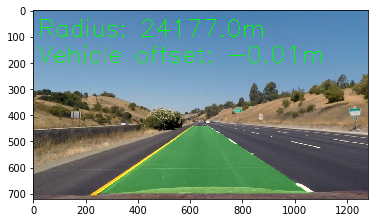

In [21]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (raw_img.shape[1], raw_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

# Add overlay for radius and offset
cv2.putText(result, 'Radius: '+str((left_curverad+right_curverad)//2)+'m', 
           (20,100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,255,0), 2, cv2.LINE_AA)
cv2.putText(result, 'Vehicle offset: '+str(offset_meter)+'m', 
           (20,200), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,255,0), 2, cv2.LINE_AA)

plt.imshow(result)

## Pipeline

In [22]:
def detect_lanes(raw_img, cameraMatrix, distCoeffs, M, Minv, warped_shape, grad_thresh_min = 20,
                grad_thresh_max = 100, s_thresh_min = 170, s_thresh_max = 255, nwindows = 9,
                margin = 100, minpix = 50):
    # Remove distortion
    undist = cv2.undistort(raw_img, cameraMatrix, distCoeffs, None, cameraMatrix)
    
    # Convert to HLS color space and extract s-channel
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    # x-gradient thresholding
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.abs(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>grad_thresh_min) & (scaled_sobel<grad_thresh_max)] = 1

    # s-channel thresholding
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>s_thresh_min) & (s_channel<s_thresh_max)] = 1

    # combine threshold binary masks
    thresh_binary = np.zeros_like(s_channel)
    thresh_binary[(s_binary==1) | (sxbinary==1)] = 1

    # warp binary mask to bird's eye
    binary_warped = cv2.warpPerspective(thresh_binary, M, warped_shape, flags=cv2.INTER_LINEAR)
    
    # detect lanes with sliding windows
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = [ind for ind in range(len(nonzerox)) 
                        if nonzerox[ind] >= win_xleft_low 
                        and nonzerox[ind] < win_xleft_high
                        and nonzeroy[ind] >= win_y_low
                        and nonzeroy[ind] < win_y_high]
        good_right_inds = [ind for ind in range(len(nonzerox)) 
                        if nonzerox[ind] >= win_xright_low 
                        and nonzerox[ind] < win_xright_high
                        and nonzeroy[ind] >= win_y_low
                        and nonzeroy[ind] < win_y_high]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.int32(np.concatenate(left_lane_inds))
    right_lane_inds = np.int32(np.concatenate(right_lane_inds))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # fit polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # evaluate curve radius
    left_curverad = calc_radius_meter(binary_warped.shape[0], left_fit, ym_per_pix, xm_per_pix)
    right_curverad = calc_radius_meter(binary_warped.shape[0], right_fit, ym_per_pix, xm_per_pix)  
    
    # evaluate offset
    left_origin = (left_fit[0]*binary_warped.shape[0]**2+left_fit[1]*binary_warped.shape[0]+left_fit[2])
    right_origin = (right_fit[0]*binary_warped.shape[0]**2+right_fit[1]*binary_warped.shape[0]+right_fit[2])
    lane_center = right_origin/2 + left_origin/2
    camera_pos = binary_warped.shape[1]//2
    offset = camera_pos - lane_center
    offset_meter = np.round(offset*xm_per_pix, 2)
    
    # Create output image
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (raw_img.shape[1], raw_img.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    ## Add overlay for radius and offset
    cv2.putText(result, 'Radius: '+str((left_curverad+right_curverad)//2)+'m', 
               (20,100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,255,0), 2, cv2.LINE_AA)
    cv2.putText(result, 'Vehicle offset: '+str(offset_meter)+'m', 
               (20,200), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,255,0), 2, cv2.LINE_AA)
    
    return result

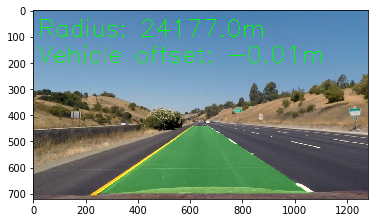

In [23]:
ann_test_img = detect_lanes(raw_img, cameraMatrix, distCoeffs, M, Minv, warped_shape)
plt.imshow(ann_test_img)

## Process video

In [24]:
def process_video(image):
    ann_img = detect_lanes(image, cameraMatrix, distCoeffs, M, Minv, warped_shape)
    return ann_img

In [25]:
# project video
output = 'test_videos_output/project_video_annotated.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,10)
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_annotated.mp4
[MoviePy] Writing video test_videos_output/project_video_annotated.mp4


100%|█████████▉| 1260/1261 [15:58<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_annotated.mp4 

CPU times: user 39min 18s, sys: 29.3 s, total: 39min 48s
Wall time: 15min 58s


In [ ]:
# challenge video
output = 'test_videos_output/challenge_video_annotated.mp4'
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(0,5)
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)

In [ ]:
# harder challenge video
output = 'test_videos_output/harder_challenge_video_annotated.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")#.subclip(0,5)
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)